# VGG16 Task A

In [1]:
import os
import numpy as np
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm


print(f"Torch version: {torch.__version__}")

Torch version: 2.4.0+cu118


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

cuda


## Problem Statement and motivation
In this project, our aims are to classify different category for fashion design items. We are separate into two different problems; one is for the main category classification problem with clothing, shoes, accessories, and bags. The other problem contains a more detailed subcategory. The total number of classes is 31. The most challenging part is imbalanced sample class distribution for subcategory classification. We need to solve the strathfield splitting problem first and then modify the current dataset to improve the performance of the model. 

In this project, our motivations are to compare different models for both above mentioned problem and predict fashion design items. It will help clients to add items easily or more efficiently for item classification.  

## 1. Generate Dataset

The UT Fashion 100 dataset consists of two parts: AAT and LAT. Base on the requirement, the goal is to classify items into 4 main categories.

However, the labels for the images in AAT and LAT are embedded within a JSON structure, and LAT contains more than the 4 required categories. The first step is to filter and select images corresponding to the 4 main categories along with their labels from both AAT and LAT datasets.

`shoes, clothing, accessories, bags`

In [3]:
# path of images and labels
aat_image_dir = '/mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/image'
aat_label_file = '/mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label/AAT.json'


In [4]:
def parse_label(label_str, flag='AAT'):
    """
    Split the string from json to get the image file's name and with its label
    : params label_str: string item from json
    : params flag: the kind of dataset. AAT and LAT have different method to label in their json file
    """
    if flag == "AAT":
        main_class, temp = label_str.split('/')
        sub_class, image_id = temp.split('_')
    else:
        main_class, image_id = label_str.split('_')
    return main_class, sub_class, image_id

# The 4 labels in task
main_classes = ['Accessories', 'Clothings', 'Bags', 'Shoes']
print("Main classes:", main_classes)


Main classes: ['Accessories', 'Clothings', 'Bags', 'Shoes']


In [5]:
class FashionDataset(Dataset):
    def __init__(self, aat_image_dir, aat_json_file, main_classes, main=True, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.main_classes = main_classes
        self.main_flag = main
        # Add image paths and labels
        self.add_data(json_file=aat_json_file, image_dir=aat_image_dir, flag='AAT')


    def add_data(self, json_file, image_dir, flag):
        """
        Append image path and its label to list by the json file.
        """
        with open(json_file, 'r') as f:
            scripts = json.load(f)
            for ls in scripts:
                for question in ls['question']:
                    main_class, sub_class, image_id = parse_label(question, flag)
                    if not self.main_flag:
                        main_class = sub_class
                    img_path = os.path.join(image_dir, f"{image_id}.jpg")
                    if os.path.exists(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(main_class)
                for question in ls['answers']:
                    main_class, sub_class, image_id = parse_label(question, flag)
                    if not self.main_flag:
                        main_class = sub_class
                    img_path = os.path.join(image_dir, f"{image_id}.jpg")
                    if os.path.exists(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(main_class)

    def __len__(self):
        """
        Return the size of dataset
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        The core to generate dataset
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
naive_transform = transforms.Compose([
    transforms.ToTensor(),
])
# generate dataset
dataset = FashionDataset(aat_image_dir=aat_image_dir,
            aat_json_file=aat_label_file,
            main_classes=main_classes,
            transform=naive_transform)

In [7]:
# shape of image
img = dataset[0][0]
print(f"The shape of image is: {img.shape}")
# length of dataset
print(f"The size of dataset is: {len(dataset)}")

The shape of image is: torch.Size([3, 1088, 962])
The size of dataset is: 983


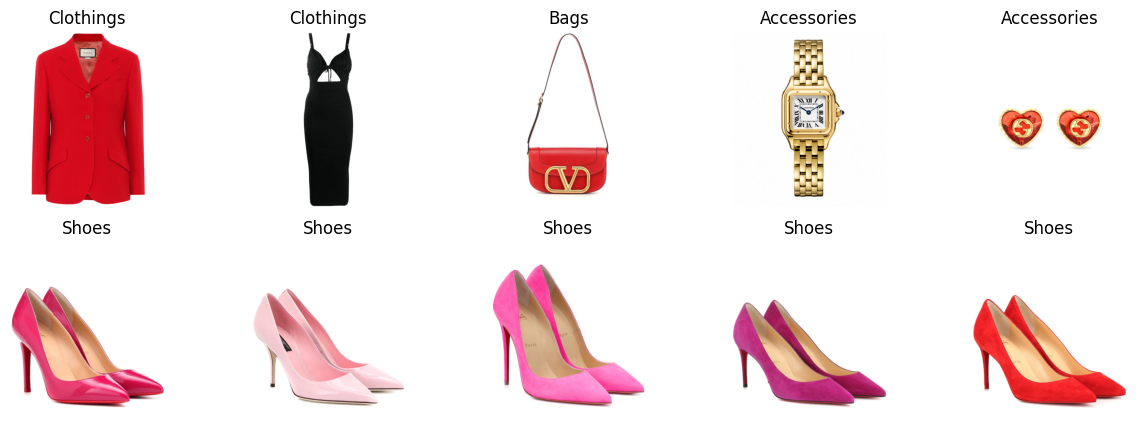

In [8]:
def show_images(dataset):
    to_pil = transforms.ToPILImage()
    num_images = 10
    cols = 5
    rows = 2
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        img = to_pil(dataset[i][0])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(dataset[i][1])
        plt.axis('off')

    plt.show()

show_images(dataset)

In [9]:
def cal_mean_std(dataset):
    means = []
    stds = []
    for i in dataset:
        image = i[0]
        means.append(image.mean([1,2]).numpy())
        stds.append(image.std([1,2]).numpy())
    return np.mean(means, axis=0), np.mean(stds, axis=0)

In [10]:
mean_array, std_array = cal_mean_std(dataset)
print(mean_array, std_array)

[0.8594327  0.83811224 0.8277409 ] [0.20753734 0.23299517 0.24600929]


## 2. Split dataset

The filtered dataset has 1317 images, we need to divide the whole dataset into train, valid, and test part. However, after splitting, the data size is too small. So we need to use the data augment method to artificially increase the size of the training set.

This category is used to receive the divided data set and form a dataloader that can load data.

In [11]:
class SplitDataset(Dataset):
    """
    To receive splited dataset and apply transform
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## 3. Transforms

In [12]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),                                     # Make the image flip randomly
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),             # Put images in perspective and simulate different viewing angles
    transforms.Resize((224,224)),                                          # Set the size to 224 according to the input requirements of torch
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     # Normalize using ImageNet-based image mean vector and standard deviation vector
    # transforms.Normalize(list(mean_array), list(std_array))                # Because it is trained from scratch, the mean standard deviation of the data set image is used to do
])

# No data augmentation is required on the validation test set
val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # transforms.Normalize(list(mean_array), list(std_array))
])

## 4. For the stratified_split_1:

we use the method of hierarchically dividing the data set to evenly divide each label into the training set and validation set to avoid uneven distribution that may result in a certain label not being included in the validation set.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
image_paths, labels = dataset.image_paths, dataset.labels

# First split, divide the data set into train 70% and temporary 30%
stratified_split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(stratified_split_1.split(image_paths, labels))
# Form the corresponding labels in the temporary set into a new list
temp_labels = [labels[i] for i in temp_idx]

# Second split: split the temporary set (20%) into validation set (2/3) and test set (1/3)
stratified_split_2 = StratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=42)
val_idx, test_idx = next(stratified_split_2.split(np.zeros(len(temp_labels)), temp_labels))


# apply transforms to each part
train_dataset = SplitDataset([dataset.image_paths[i] for i in train_idx],
                              [dataset.labels[i] for i in train_idx],
                              transform=train_transforms)

val_dataset = SplitDataset([dataset.image_paths[i] for i in val_idx],
                            [dataset.labels[i] for i in val_idx],
                            transform=val_test_transforms)

test_dataset = SplitDataset([dataset.image_paths[i] for i in test_idx],
                             [dataset.labels[i] for i in test_idx],
                             transform=val_test_transforms)

# generate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

dataloaders = {'train':train_loader, 'val':val_loader, 'test':test_loader}

train_batch = next(iter(dataloaders['train']))
print(f'train batch size: {np.array(train_batch[0]).shape}')
val_batch = next(iter(dataloaders['val']))
print(f'val batch size: {np.array(val_batch[0]).shape}')
test_batch = next(iter(dataloaders['test']))
print(f'test batch size: {np.array(test_batch[0]).shape}')

train batch size: (32, 3, 224, 224)
val batch size: (32, 3, 224, 224)
test batch size: (32, 3, 224, 224)


In [14]:
from collections import Counter
print(Counter([labels[i] for i in train_idx]))
print(Counter([labels[i] for i in val_idx]))
print(Counter([labels[i] for i in test_idx]))

Counter({'Accessories': 233, 'Clothings': 209, 'Shoes': 128, 'Bags': 118})
Counter({'Clothings': 71, 'Shoes': 53, 'Accessories': 49, 'Bags': 23})
Counter({'Clothings': 34, 'Accessories': 32, 'Shoes': 17, 'Bags': 16})


## 5. Modifying the VGG16 Model

In [25]:
# Load VGG16 model
model = models.vgg16(weights=None)
num_ftrs = model.classifier[-1].in_features

# Modify the final classification layer
Last_layer = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(num_ftrs, 128)),
            # ('relu1', nn.ReLU()),
            ('dropout1', nn.Dropout(p=0.3)),
            ('fc2', nn.Linear(128, len(main_classes)))])
        )

# Replace the classification layer of VGG16
model.classifier[-1] = Last_layer
model = model.to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 6. Set parameters

In [26]:
# set paramaters
num_epochs = 20
criterion = nn.CrossEntropyLoss()                                                           # use CE as loss function
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)      # use SGD algorithm to update weights
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)    # use shceduler to adjuest learning rate
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

## 7. Training and Evaluating VGG16 Model

In [27]:
def compute_metrics_per_class(labels, preds, num_classes):
    f1 = f1_score(labels, preds, average=None, labels=range(num_classes))
    
    # One-hot encoding for AUROC and AUPRC calculation
    labels_one_hot = np.eye(num_classes)[labels]
    preds_one_hot = np.eye(num_classes)[preds]
    
    auroc = roc_auc_score(labels_one_hot, preds_one_hot, average=None, multi_class='ovr')
    auprc = average_precision_score(labels_one_hot, preds_one_hot, average=None)
    
    return f1, auroc, auprc

def compute_final_metrics(model, dataloader, main_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = [main_classes.index(label) for label in labels]
            labels = torch.tensor(labels).to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    num_classes = len(main_classes)
    accuracy = accuracy_score(all_labels, all_preds)
    f1, auroc, auprc = compute_metrics_per_class(all_labels, all_preds, num_classes)
    
    return accuracy, f1, auroc, auprc, all_labels, all_preds

def compute_epoch_auc(model, dataloader, main_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = [main_classes.index(label) for label in labels]
            labels = torch.tensor(labels).to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    num_classes = len(main_classes)
    labels_one_hot = np.eye(num_classes)[all_labels]
    preds_one_hot = np.eye(num_classes)[all_preds]
    auroc = roc_auc_score(labels_one_hot, preds_one_hot, average='macro', multi_class='ovr')
    
    return auroc

def compute_epoch_f1(model, dataloader, main_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = [main_classes.index(label) for label in labels]
            labels = torch.tensor(labels).to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1

def train_model(model, criterion, optimizer, scheduler, dataloaders, main_classes, num_epochs):
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    train_auc = []
    val_auc = []
    train_f1 = []
    val_f1 = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs} Start')

        for step in ['train', 'val']:
            if step == 'train':
                model.train()
            else:
                model.eval()

            data_size = len(dataloaders[step].dataset)
            cur_loss, cur_corrects = 0, 0
            all_labels = []
            all_preds = []

            dataloader = tqdm(dataloaders[step], desc=f'{step} Epoch {epoch+1}')

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = [main_classes.index(label) for label in labels]
                labels = torch.tensor(labels).to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(step == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if step == 'train':
                        loss.backward()
                        optimizer.step()

                cur_loss += loss.item() * inputs.size(0)
                cur_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            if step == 'train':
                scheduler.step()

            mean_loss = float(cur_loss / data_size)
            mean_acc = float(cur_corrects / data_size)
            labels_one_hot = np.eye(len(main_classes))[all_labels]
            preds_one_hot = np.eye(len(main_classes))[all_preds]
            mean_auc = roc_auc_score(labels_one_hot, preds_one_hot, average='macro', multi_class='ovr')
            mean_f1 = f1_score(all_labels, all_preds, average='macro')

            if step == 'train':
                train_acc.append(mean_acc)
                train_loss.append(mean_loss)
                train_auc.append(mean_auc)
                train_f1.append(mean_f1)
            else:
                val_acc.append(mean_acc)
                val_loss.append(mean_loss)
                val_auc.append(mean_auc)
                val_f1.append(mean_f1)

            print(f'{step} loss: {mean_loss:.4f}; {step} acc: {mean_acc:.4f}; {step} AUC: {mean_auc:.4f}; {step} F1: {mean_f1:.4f}')

        print(f"{'='*25}Epoch {epoch+1} Finished{'='*25}")

    train_log_dict = {'train_acc':train_acc, 'train_loss':train_loss, 'val_acc':val_acc, 'val_loss':val_loss, 'train_auc':train_auc, 'val_auc':val_auc, 'train_f1': train_f1, 'val_f1': val_f1}
    return model, train_log_dict


In [59]:
def plot_training_history(train_acc, train_loss, val_acc, val_loss, train_auc, val_auc, train_f1, val_f1):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(14, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_acc, 'blue', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'red', label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_loss, 'blue', label='Train Loss')
    plt.plot(epochs, val_loss, 'red', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_auc, 'blue', label='Train AUROC')
    plt.plot(epochs, val_auc, 'red', label='Validation AUROC')
    plt.title('Train and Validation AUROC')
    plt.xlabel('Epochs')
    plt.ylabel('AUROC')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_f1, 'blue', label='Train F1-score')
    plt.plot(epochs, val_f1, 'red', label='Validation F1-score')
    plt.title('Train and Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
trained_model, log = train_model(model, criterion, optimizer, scheduler, dataloaders, main_classes, num_epochs)
accuracy, f1, auroc, auprc, all_labels, all_preds = compute_final_metrics(trained_model, dataloaders['test'], main_classes)

print(f'Overall accuracy: {accuracy:.4f}')
for i, class_name in enumerate(main_classes):
    print(f'Class: {class_name}')
    print(f'  Accuracy: {accuracy_score(np.array(all_labels) == i, np.array(all_preds) == i):.4f}')
    print(f'  F1-score: {f1[i]:.4f}')
    print(f'  AUROC: {auroc[i]:.4f}')
    print(f'  AUPRC: {auprc[i]:.4f}')



Epoch 1/20 Start


train Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.17s/it]


train loss: 1.3566; train acc: 0.3401; train AUC: 0.5065; train F1: 0.1962


val Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s]


val loss: 1.3891; val acc: 0.2500; val AUC: 0.5000; val F1: 0.1000
=========================Epoch 1 Finished=========================
Epoch 2/20 Start


train Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.15s/it]


train loss: 1.3429; train acc: 0.3605; train AUC: 0.5191; train F1: 0.2140


val Epoch 2: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s]


val loss: 1.4089; val acc: 0.2500; val AUC: 0.5000; val F1: 0.1000
=========================Epoch 2 Finished=========================
Epoch 3/20 Start


train Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.16s/it]


train loss: 1.3241; train acc: 0.3721; train AUC: 0.5331; train F1: 0.2355


val Epoch 3: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


val loss: 1.3538; val acc: 0.3622; val AUC: 0.5000; val F1: 0.1330
=========================Epoch 3 Finished=========================
Epoch 4/20 Start


train Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.17s/it]


train loss: 1.2458; train acc: 0.4099; train AUC: 0.5592; train F1: 0.3026


val Epoch 4: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


val loss: 0.8543; val acc: 0.6429; val AUC: 0.7459; val F1: 0.6039
=========================Epoch 4 Finished=========================
Epoch 5/20 Start


train Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.21s/it]


train loss: 1.2220; train acc: 0.4331; train AUC: 0.5840; train F1: 0.3536


val Epoch 5: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


val loss: 0.8590; val acc: 0.5765; val AUC: 0.7188; val F1: 0.4759
=========================Epoch 5 Finished=========================
Epoch 6/20 Start


train Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.22s/it]


train loss: 1.1670; train acc: 0.4535; train AUC: 0.6087; train F1: 0.4217


val Epoch 6: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


val loss: 1.0946; val acc: 0.4643; val AUC: 0.6463; val F1: 0.4372
=========================Epoch 6 Finished=========================
Epoch 7/20 Start


train Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.22s/it]


train loss: 1.0933; train acc: 0.5073; train AUC: 0.6505; train F1: 0.4802


val Epoch 7: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


val loss: 0.7829; val acc: 0.6582; val AUC: 0.7162; val F1: 0.5737
=========================Epoch 7 Finished=========================
Epoch 8/20 Start


train Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.22s/it]


train loss: 1.0867; train acc: 0.5015; train AUC: 0.6512; train F1: 0.4520


val Epoch 8: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


val loss: 0.8513; val acc: 0.6684; val AUC: 0.7341; val F1: 0.5507
=========================Epoch 8 Finished=========================
Epoch 9/20 Start


train Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.17s/it]


train loss: 0.9525; train acc: 0.6119; train AUC: 0.7176; train F1: 0.5722


val Epoch 9: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


val loss: 0.7378; val acc: 0.6582; val AUC: 0.7663; val F1: 0.6220
=========================Epoch 9 Finished=========================
Epoch 10/20 Start


train Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:27<00:00,  1.23s/it]


train loss: 0.8790; train acc: 0.6337; train AUC: 0.7357; train F1: 0.5992


val Epoch 10: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


val loss: 1.0469; val acc: 0.6888; val AUC: 0.7588; val F1: 0.6321
=========================Epoch 10 Finished=========================
Epoch 11/20 Start


train Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.23s/it]


train loss: 0.8837; train acc: 0.6672; train AUC: 0.7590; train F1: 0.6420


val Epoch 11: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


val loss: 0.7872; val acc: 0.7449; val AUC: 0.7874; val F1: 0.6992
=========================Epoch 11 Finished=========================
Epoch 12/20 Start


train Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.22s/it]


train loss: 0.9450; train acc: 0.6744; train AUC: 0.7676; train F1: 0.6541


val Epoch 12: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.63it/s]


val loss: 0.7360; val acc: 0.6990; val AUC: 0.7809; val F1: 0.6661
=========================Epoch 12 Finished=========================
Epoch 13/20 Start


train Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.21s/it]


train loss: 0.8391; train acc: 0.6642; train AUC: 0.7561; train F1: 0.6392


val Epoch 13: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


val loss: 0.6758; val acc: 0.6990; val AUC: 0.7862; val F1: 0.6676
=========================Epoch 13 Finished=========================
Epoch 14/20 Start


train Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.21s/it]


train loss: 0.7993; train acc: 0.6802; train AUC: 0.7700; train F1: 0.6559


val Epoch 14: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


val loss: 0.6159; val acc: 0.7194; val AUC: 0.7875; val F1: 0.6691
=========================Epoch 14 Finished=========================
Epoch 15/20 Start


train Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.22s/it]


train loss: 0.7535; train acc: 0.6846; train AUC: 0.7717; train F1: 0.6589


val Epoch 15: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


val loss: 0.6130; val acc: 0.7194; val AUC: 0.8024; val F1: 0.6875
=========================Epoch 15 Finished=========================
Epoch 16/20 Start


train Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.20s/it]


train loss: 0.7102; train acc: 0.7297; train AUC: 0.8051; train F1: 0.7138


val Epoch 16: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


val loss: 0.6011; val acc: 0.7296; val AUC: 0.8105; val F1: 0.7002
=========================Epoch 16 Finished=========================
Epoch 17/20 Start


train Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:27<00:00,  1.24s/it]


train loss: 0.6937; train acc: 0.7311; train AUC: 0.8060; train F1: 0.7116


val Epoch 17: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.77it/s]


val loss: 0.6140; val acc: 0.7296; val AUC: 0.8107; val F1: 0.6996
=========================Epoch 17 Finished=========================
Epoch 18/20 Start


train Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:27<00:00,  1.23s/it]


train loss: 0.7110; train acc: 0.7151; train AUC: 0.7965; train F1: 0.6977


val Epoch 18: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


val loss: 0.5663; val acc: 0.7500; val AUC: 0.8301; val F1: 0.7264
=========================Epoch 18 Finished=========================
Epoch 19/20 Start


train Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.21s/it]


train loss: 0.6343; train acc: 0.7442; train AUC: 0.8155; train F1: 0.7250


val Epoch 19: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


val loss: 0.5615; val acc: 0.7500; val AUC: 0.8237; val F1: 0.7215
=========================Epoch 19 Finished=========================
Epoch 20/20 Start


train Epoch 20: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.19s/it]


train loss: 0.6678; train acc: 0.7340; train AUC: 0.8085; train F1: 0.7147


val Epoch 20: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]


val loss: 0.5581; val acc: 0.7500; val AUC: 0.8237; val F1: 0.7215
=========================Epoch 20 Finished=========================
Overall accuracy: 0.7071
Class: Accessories
  Accuracy: 0.8788
  F1-score: 0.8182
  AUROC: 0.8696
  AUPRC: 0.7205
Class: Clothings
  Accuracy: 0.8182
  F1-score: 0.7500
  AUROC: 0.8124
  AUPRC: 0.6349
Class: Bags
  Accuracy: 0.8485
  F1-score: 0.4444
  AUROC: 0.6574
  AUPRC: 0.3056
Class: Shoes
  Accuracy: 0.8687
  F1-score: 0.6061
  AUROC: 0.7575
  AUPRC: 0.4384


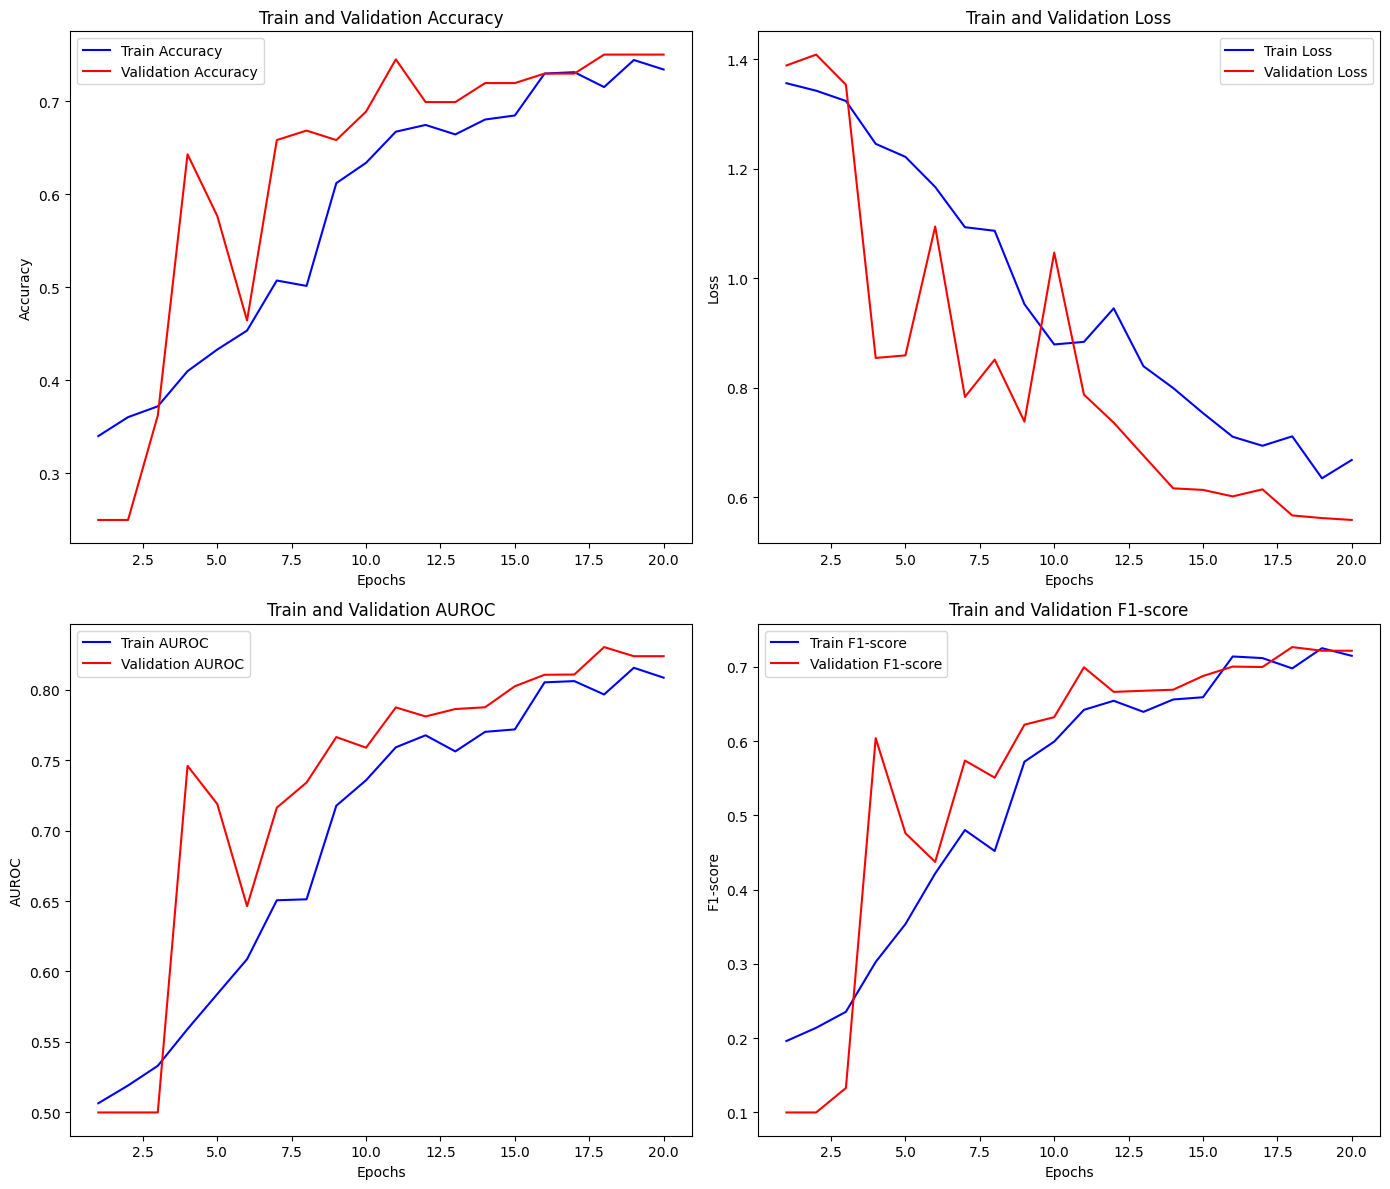

In [60]:
plot_training_history(log['train_acc'], log['train_loss'], log['val_acc'], log['val_loss'], log['train_auc'], log['val_auc'],log['train_f1'],log['val_f1'])

## 8. Result

### Overall Accuracy
Overall accuracy: 0.6970

### Class-wise Metrics
- **Class: Accessories**
  - Accuracy: 0.8788
  - F1-score: 0.8182
  - AUROC: 0.8696
  - AUPRC: 0.7205

- **Class: Clothings**
  - Accuracy: 0.7879
  - F1-score: 0.7042
  - AUROC: 0.7753
  - AUPRC: 0.5877

- **Class: Bags**
  - Accuracy: 0.8485
  - F1-score: 0.4000
  - AUROC: 0.6322
  - AUPRC: 0.2847

- **Class: Shoes**
  - Accuracy: 0.8788
  - F1-score: 0.6667
  - AUROC: 0.8103
  - AUPRC: 0.4963


In [22]:
# save model
model_path = './vgg16_4calss_model.pth'
torch.save(trained_model.state_dict(), model_path)

## VGG16 Task B

## 1. Custom Dataset and Edge Detection

In [63]:
import os
import json
import time
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, average_precision_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from torchvision.models import vgg16
from sklearn.preprocessing import label_binarize
class CustomDataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform
        self.data, self.sub_classes = self.load_data()
        self.sub_classes = list(set(self.sub_classes))
    
    def load_data(self):
        data = []
        sub_classes = []
        label_files = [f for f in os.listdir(self.label_folder) if f.endswith('.json')]
        
        print(f"Found {len(label_files)} JSON files in {self.label_folder}")
        
        for label_file in label_files:
            label_path = os.path.join(self.label_folder, label_file)
            print(f"Reading JSON file: {label_path}")
            with open(label_path, 'r', encoding='utf-8') as f:
                try:
                    annotations = json.load(f)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON file {label_path}: {e}")
                    continue
                
                for annotation in annotations:
                    for field in ['question', 'answers']:
                        images = annotation.get(field, [])
                        for image in images:
                            try:
                                super_category, image_name = image.split('/')
                                img_name = image_name.split('_')[-1] + '.jpg'
                                sub_class = image_name.split('_')[0]
                                img_path = os.path.join(self.img_folder, img_name)
                                if os.path.exists(img_path):
                                    data.append((img_path, sub_class))
                                    sub_classes.append(sub_class)
                                else:
                                    print(f"Image not found: {img_path}")
                            except ValueError as e:
                                print(f"Error parsing image {image} in file {label_path}: {e}")
                                continue
        print(f"Loaded {len(data)} image paths and labels")
        return data, sub_classes

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sub_class = self.data[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros((3, 224, 224)), self.sub_classes.index(sub_class)
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.sub_classes.index(sub_class)

    def split_dataset(self, test_size=0.3, random_state=42):
        category_image_dict = {}
        for img_path, sub_class in self.data:
            if sub_class not in category_image_dict:
                category_image_dict[sub_class] = []
            category_image_dict[sub_class].append((img_path, sub_class))
        
        train_data = []
        val_data = []
        
        for sub_class, items in category_image_dict.items():
            train, val = train_test_split(items, test_size=test_size, random_state=random_state)
            train_data.extend(train)
            val_data.extend(val)
        
        return train_data, val_data

class EdgeDetection(object):
    def __call__(self, img):
        img = np.array(img)
        edges = cv2.Canny(img, 100, 200)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(edges)

## 2. DataLoder

In [35]:
img_folder = '/mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/image'
label_folder = '/mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((224,224)),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [36]:
dataset = CustomDataset(img_folder, label_folder, transform=data_transforms['train'])
print(f"Total dataset size: {len(dataset)}")

Found 1 JSON files in /mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label
Reading JSON file: /mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label/AAT.json
Loaded 983 image paths and labels
Total dataset size: 983


## 3. Split dataset

In [37]:
def cal_mean_std(dataset):
    means = []
    stds = []
    for i in dataset:
        image = i[0]
        means.append(image.mean([1,2]).numpy())
        stds.append(image.std([1,2]).numpy())
    return np.mean(means, axis=0), np.mean(stds, axis=0)
    
mean_array, std_array = cal_mean_std(dataset)

# Split the training set and validation set proportionally
train_data, val_data = dataset.split_dataset(test_size=0.3)

train_dataset = CustomDataset(img_folder, label_folder, transform=data_transforms['train'])
val_dataset = CustomDataset(img_folder, label_folder, transform=data_transforms['validation'])

train_dataset.data = train_data
val_dataset.data = val_data

train_dataset.transform = data_transforms['train']
val_dataset.transform = data_transforms['validation']

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Check training and validation set sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Found 1 JSON files in /mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label
Reading JSON file: /mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label/AAT.json
Loaded 983 image paths and labels
Found 1 JSON files in /mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label
Reading JSON file: /mnt/c/Users/user/Desktop/9444proj/A100_dataset/AAT/label/AAT.json
Loaded 983 image paths and labels
Train dataset size: 672
Validation dataset size: 311


In [39]:
# Get the category name from the training set
sub_class_names = train_dataset.sub_classes

dataloaders = {
    'train': train_loader,
    'validation': val_loader,
}

dataset_sizes = {'train': len(train_dataset), 'validation': len(val_dataset)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 4. Modifying the VGG16 Model
using the pretrain weight

In [64]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1) 
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2), 
            nn.Linear(in_features=1000, out_features=31)
        )

    def forward(self, x):
        t = self.vgg16(x)
        output = self.classifier(t)
        return output

model = Network().to(device)
criterion_sub = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

scaler = torch.amp.GradScaler()

In [65]:
model

Network(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

## 5. Plotting Metrics and Training History

### Plotting Class-wise Metrics

The `plot_metrics` function creates bar plots to visualize the F1-score, AUROC, and AUPRC for each class.

```python

In [52]:
def predict_image(img_path):
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs_sub = model(img_tensor)
        _, preds_sub = torch.max(outputs_sub, 1)

    return sub_class_names[preds_sub[0]]

## 6. Training and Evaluating the Model

In [53]:

def train_model(model, criterion_sub, optimizer, scheduler, num_epochs=25):
    history = {
        'train_loss': [],
        'train_acc_sub': [],
        'val_loss': [],
        'val_acc_sub': [],
        'train_f1': [],
        'val_f1': [],
        'train_auc': [],
        'val_auc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        start_time = time.time()
        
        # Reset labels and predictions for confusion matrix calculation
        all_labels = {'train': [], 'validation': []}
        all_preds = {'train': [], 'validation': []}
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects_sub = 0
            all_sub_labels = []
            all_preds_sub = []

            dataloader = dataloaders[phase]
            for inputs, sub_labels in tqdm(dataloader, desc=f'{phase.capitalize()} Epoch {epoch + 1}/{num_epochs}'):
                inputs = inputs.to(device)
                sub_labels = sub_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.amp.autocast(device_type='cuda'):
                        outputs_sub = model(inputs)
                        _, preds_sub = torch.max(outputs_sub, 1)
                        loss_sub = criterion_sub(outputs_sub, sub_labels)

                    if phase == 'train':
                        scaler.scale(loss_sub).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss_sub.item() * inputs.size(0)
                running_corrects_sub += torch.sum(preds_sub == sub_labels.data)
                all_sub_labels.extend(sub_labels.cpu().numpy())
                all_preds_sub.extend(preds_sub.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc_sub = running_corrects_sub.double() / dataset_sizes[phase]

            all_labels[phase] = all_sub_labels
            all_preds[phase] = all_preds_sub

            epoch_f1 = f1_score(all_sub_labels, all_preds_sub, average='weighted')
            y_true_binary = label_binarize(all_sub_labels, classes=range(len(sub_class_names)))
            y_pred_binary = label_binarize(all_preds_sub, classes=range(len(sub_class_names)))
            epoch_auc = roc_auc_score(y_true_binary, y_pred_binary, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc_sub:.4f} F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc_sub'].append(epoch_acc_sub.item())
                history['train_f1'].append(epoch_f1)
                history['train_auc'].append(epoch_auc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc_sub'].append(epoch_acc_sub.item())
                history['val_f1'].append(epoch_f1)
                history['val_auc'].append(epoch_auc)

        elapsed_time = time.time() - start_time
        print(f'Epoch {epoch + 1} completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')
        print()

    for phase in ['train', 'validation']:
        cm_sub = confusion_matrix(all_labels[phase], all_preds[phase])

        print(f'Subclass Confusion Matrix ({phase}):')
        plt.figure(figsize=(12, 10))  # Increase figure size for better readability
        sns.heatmap(cm_sub, annot=True, fmt="d", cmap="Blues", xticklabels=sub_class_names, yticklabels=sub_class_names, cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Subclass Confusion Matrix ({phase})')
        plt.show()

        accuracy = accuracy_score(all_labels[phase], all_preds[phase])
        f1 = f1_score(all_labels[phase], all_preds[phase], average='weighted')
        try:
            y_true_binary = label_binarize(all_labels[phase], classes=range(len(sub_class_names)))
            y_pred_binary = label_binarize(all_preds[phase], classes=range(len(sub_class_names)))
            auroc = roc_auc_score(y_true_binary, y_pred_binary, average='macro')
            auprc = average_precision_score(y_true_binary, y_pred_binary, average='macro')
        except ValueError:
            auroc = "AUROC can't be calculated for this dataset"
            auprc = "AUPRC can't be calculated for this dataset"

        print(f'Final {phase} F1 Score: {f1:.4f}')
        print(f'Final {phase} AUROC: {auroc}')

        f1_per_class = f1_score(all_labels[phase], all_preds[phase], average=None, labels=range(len(sub_class_names)))
        try:
            auroc_per_class = roc_auc_score(y_true_binary, y_pred_binary, average=None)
            auprc_per_class = average_precision_score(y_true_binary, y_pred_binary, average=None)
        except ValueError:
            auroc_per_class = ["AUROC can't be calculated for this dataset"] * len(sub_class_names)
            auprc_per_class = ["AUPRC can't be calculated for this dataset"] * len(sub_class_names)

        for i, class_name in enumerate(sub_class_names):
            print(f'Class: {class_name}')
            print(f'  F1-score: {f1_per_class[i]:.4f}')
            print(f'  AUROC: {auroc_per_class[i]}')

    return model, history



In [57]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_acc_sub'], 'blue', label='Train Accuracy')
    plt.plot(epochs, history['val_acc_sub'], 'red', label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_loss'], 'blue', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'red', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_f1'], 'blue', label='Train F1-score')
    plt.plot(epochs, history['val_f1'], 'red', label='Validation F1-score')
    plt.title('Train and Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_auc'], 'blue', label='Train AUROC')
    plt.plot(epochs, history['val_auc'], 'red', label='Validation AUROC')
    plt.title('Train and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()



Using device: cuda:0
Epoch 1/50
----------


Train Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 3.9818 Acc: 0.0580 F1: 0.0392 AUC: 0.4984


Validation Epoch 1/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


validation Loss: 3.4415 Acc: 0.0707 F1: 0.0093 AUC: 0.5000
Epoch 1 completed in 0m 22s

Epoch 2/50
----------


Train Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.31it/s]


train Loss: 3.3042 Acc: 0.1131 F1: 0.0507 AUC: 0.5112


Validation Epoch 2/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


validation Loss: 3.2033 Acc: 0.1479 F1: 0.0690 AUC: 0.5267
Epoch 2 completed in 0m 22s

Epoch 3/50
----------


Train Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.30it/s]


train Loss: 2.8136 Acc: 0.1801 F1: 0.1367 AUC: 0.5371


Validation Epoch 3/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


validation Loss: 2.6015 Acc: 0.1704 F1: 0.0781 AUC: 0.5351
Epoch 3 completed in 0m 22s

Epoch 4/50
----------


Train Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.29it/s]


train Loss: 2.5380 Acc: 0.2068 F1: 0.1693 AUC: 0.5577


Validation Epoch 4/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


validation Loss: 2.4451 Acc: 0.2090 F1: 0.1198 AUC: 0.5577
Epoch 4 completed in 0m 22s

Epoch 5/50
----------


Train Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.29it/s]


train Loss: 2.3214 Acc: 0.2798 F1: 0.2488 AUC: 0.5926


Validation Epoch 5/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


validation Loss: 2.6790 Acc: 0.1704 F1: 0.0850 AUC: 0.5357
Epoch 5 completed in 0m 22s

Epoch 6/50
----------


Train Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 2.2109 Acc: 0.3021 F1: 0.2642 AUC: 0.5941


Validation Epoch 6/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


validation Loss: 2.3060 Acc: 0.2797 F1: 0.2000 AUC: 0.6049
Epoch 6 completed in 0m 23s

Epoch 7/50
----------


Train Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 2.0581 Acc: 0.3185 F1: 0.2894 AUC: 0.6085


Validation Epoch 7/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 2.1776 Acc: 0.2958 F1: 0.2329 AUC: 0.6131
Epoch 7 completed in 0m 23s

Epoch 8/50
----------


Train Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.29it/s]


train Loss: 2.0089 Acc: 0.3735 F1: 0.3366 AUC: 0.6343


Validation Epoch 8/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


validation Loss: 2.1198 Acc: 0.3280 F1: 0.2588 AUC: 0.6106
Epoch 8 completed in 0m 23s

Epoch 9/50
----------


Train Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 1.8688 Acc: 0.4062 F1: 0.3640 AUC: 0.6492


Validation Epoch 9/50: 100%|████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


validation Loss: 2.1335 Acc: 0.3344 F1: 0.2954 AUC: 0.6330
Epoch 9 completed in 0m 23s

Epoch 10/50
----------


Train Epoch 10/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.24it/s]


train Loss: 1.7708 Acc: 0.4256 F1: 0.3994 AUC: 0.6603


Validation Epoch 10/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 1.8937 Acc: 0.4662 F1: 0.3995 AUC: 0.6829
Epoch 10 completed in 0m 23s

Epoch 11/50
----------


Train Epoch 11/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.21it/s]


train Loss: 1.6374 Acc: 0.4836 F1: 0.4527 AUC: 0.6934


Validation Epoch 11/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


validation Loss: 1.8779 Acc: 0.4437 F1: 0.3929 AUC: 0.6809
Epoch 11 completed in 0m 23s

Epoch 12/50
----------


Train Epoch 12/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 1.5933 Acc: 0.4658 F1: 0.4384 AUC: 0.6853


Validation Epoch 12/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


validation Loss: 1.9125 Acc: 0.4277 F1: 0.3752 AUC: 0.6609
Epoch 12 completed in 0m 23s

Epoch 13/50
----------


Train Epoch 13/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 1.5213 Acc: 0.4896 F1: 0.4692 AUC: 0.7001


Validation Epoch 13/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]


validation Loss: 1.8327 Acc: 0.4469 F1: 0.3837 AUC: 0.6777
Epoch 13 completed in 0m 23s

Epoch 14/50
----------


Train Epoch 14/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 1.4797 Acc: 0.4970 F1: 0.4700 AUC: 0.6968


Validation Epoch 14/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


validation Loss: 1.8594 Acc: 0.4148 F1: 0.3784 AUC: 0.6569
Epoch 14 completed in 0m 23s

Epoch 15/50
----------


Train Epoch 15/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 1.3851 Acc: 0.5283 F1: 0.5103 AUC: 0.7165


Validation Epoch 15/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 1.7941 Acc: 0.4662 F1: 0.4299 AUC: 0.6924
Epoch 15 completed in 0m 23s

Epoch 16/50
----------


Train Epoch 16/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 1.3124 Acc: 0.5685 F1: 0.5478 AUC: 0.7348


Validation Epoch 16/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


validation Loss: 1.8206 Acc: 0.4920 F1: 0.4480 AUC: 0.7005
Epoch 16 completed in 0m 23s

Epoch 17/50
----------


Train Epoch 17/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 1.2139 Acc: 0.5685 F1: 0.5478 AUC: 0.7394


Validation Epoch 17/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


validation Loss: 1.8344 Acc: 0.4823 F1: 0.4257 AUC: 0.6929
Epoch 17 completed in 0m 23s

Epoch 18/50
----------


Train Epoch 18/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 1.2364 Acc: 0.5804 F1: 0.5678 AUC: 0.7396


Validation Epoch 18/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


validation Loss: 1.8791 Acc: 0.4952 F1: 0.4668 AUC: 0.7009
Epoch 18 completed in 0m 23s

Epoch 19/50
----------


Train Epoch 19/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


train Loss: 1.4161 Acc: 0.5283 F1: 0.5132 AUC: 0.7245


Validation Epoch 19/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 1.7167 Acc: 0.4984 F1: 0.4416 AUC: 0.6898
Epoch 19 completed in 0m 23s

Epoch 20/50
----------


Train Epoch 20/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 1.1144 Acc: 0.6339 F1: 0.6150 AUC: 0.7730


Validation Epoch 20/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


validation Loss: 1.8471 Acc: 0.4598 F1: 0.4403 AUC: 0.6910
Epoch 20 completed in 0m 23s

Epoch 21/50
----------


Train Epoch 21/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 1.1067 Acc: 0.6280 F1: 0.6186 AUC: 0.7818


Validation Epoch 21/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 1.6343 Acc: 0.5305 F1: 0.4823 AUC: 0.7152
Epoch 21 completed in 0m 23s

Epoch 22/50
----------


Train Epoch 22/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 1.0305 Acc: 0.6518 F1: 0.6410 AUC: 0.7783


Validation Epoch 22/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


validation Loss: 1.7760 Acc: 0.5113 F1: 0.4719 AUC: 0.7087
Epoch 22 completed in 0m 23s

Epoch 23/50
----------


Train Epoch 23/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.30it/s]


train Loss: 0.9566 Acc: 0.6682 F1: 0.6496 AUC: 0.7894


Validation Epoch 23/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 1.7598 Acc: 0.5273 F1: 0.4877 AUC: 0.7233
Epoch 23 completed in 0m 22s

Epoch 24/50
----------


Train Epoch 24/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


train Loss: 0.8102 Acc: 0.7068 F1: 0.7024 AUC: 0.8196


Validation Epoch 24/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


validation Loss: 1.7606 Acc: 0.5595 F1: 0.5256 AUC: 0.7423
Epoch 24 completed in 0m 23s

Epoch 25/50
----------


Train Epoch 25/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 0.9062 Acc: 0.7054 F1: 0.6993 AUC: 0.8172


Validation Epoch 25/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


validation Loss: 1.9304 Acc: 0.5048 F1: 0.4736 AUC: 0.6992
Epoch 25 completed in 0m 23s

Epoch 26/50
----------


Train Epoch 26/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 0.8032 Acc: 0.7351 F1: 0.7283 AUC: 0.8378


Validation Epoch 26/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 1.7854 Acc: 0.5723 F1: 0.5445 AUC: 0.7498
Epoch 26 completed in 0m 23s

Epoch 27/50
----------


Train Epoch 27/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.7196 Acc: 0.7426 F1: 0.7408 AUC: 0.8436


Validation Epoch 27/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 1.8678 Acc: 0.5434 F1: 0.5157 AUC: 0.7259
Epoch 27 completed in 0m 23s

Epoch 28/50
----------


Train Epoch 28/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.6537 Acc: 0.7827 F1: 0.7794 AUC: 0.8582


Validation Epoch 28/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


validation Loss: 1.8829 Acc: 0.5498 F1: 0.5232 AUC: 0.7246
Epoch 28 completed in 0m 23s

Epoch 29/50
----------


Train Epoch 29/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 0.6708 Acc: 0.7798 F1: 0.7782 AUC: 0.8628


Validation Epoch 29/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


validation Loss: 2.2878 Acc: 0.5434 F1: 0.5193 AUC: 0.7287
Epoch 29 completed in 0m 23s

Epoch 30/50
----------


Train Epoch 30/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


train Loss: 0.6616 Acc: 0.7693 F1: 0.7692 AUC: 0.8603


Validation Epoch 30/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.53it/s]


validation Loss: 2.2095 Acc: 0.5370 F1: 0.5019 AUC: 0.7173
Epoch 30 completed in 0m 23s

Epoch 31/50
----------


Train Epoch 31/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 0.6550 Acc: 0.7723 F1: 0.7677 AUC: 0.8578


Validation Epoch 31/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 2.0022 Acc: 0.5305 F1: 0.5039 AUC: 0.7154
Epoch 31 completed in 0m 23s

Epoch 32/50
----------


Train Epoch 32/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.20it/s]


train Loss: 0.5475 Acc: 0.8185 F1: 0.8163 AUC: 0.8842


Validation Epoch 32/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 2.1796 Acc: 0.5370 F1: 0.5119 AUC: 0.7238
Epoch 32 completed in 0m 24s

Epoch 33/50
----------


Train Epoch 33/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 0.5731 Acc: 0.8110 F1: 0.8098 AUC: 0.8970


Validation Epoch 33/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


validation Loss: 2.6793 Acc: 0.5273 F1: 0.4997 AUC: 0.7112
Epoch 33 completed in 0m 23s

Epoch 34/50
----------


Train Epoch 34/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 0.5225 Acc: 0.8274 F1: 0.8260 AUC: 0.8858


Validation Epoch 34/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


validation Loss: 2.1389 Acc: 0.5338 F1: 0.5275 AUC: 0.7166
Epoch 34 completed in 0m 23s

Epoch 35/50
----------


Train Epoch 35/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 0.4407 Acc: 0.8393 F1: 0.8379 AUC: 0.8952


Validation Epoch 35/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


validation Loss: 2.4775 Acc: 0.5434 F1: 0.5155 AUC: 0.7194
Epoch 35 completed in 0m 23s

Epoch 36/50
----------


Train Epoch 36/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 0.5404 Acc: 0.8423 F1: 0.8385 AUC: 0.9004


Validation Epoch 36/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


validation Loss: 2.0821 Acc: 0.5531 F1: 0.5399 AUC: 0.7332
Epoch 36 completed in 0m 23s

Epoch 37/50
----------


Train Epoch 37/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.5027 Acc: 0.8289 F1: 0.8275 AUC: 0.8915


Validation Epoch 37/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


validation Loss: 2.0349 Acc: 0.5595 F1: 0.5446 AUC: 0.7355
Epoch 37 completed in 0m 23s

Epoch 38/50
----------


Train Epoch 38/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.4737 Acc: 0.8393 F1: 0.8382 AUC: 0.9046


Validation Epoch 38/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 2.4718 Acc: 0.5273 F1: 0.5028 AUC: 0.7213
Epoch 38 completed in 0m 23s

Epoch 39/50
----------


Train Epoch 39/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.5480 Acc: 0.8140 F1: 0.8127 AUC: 0.8815


Validation Epoch 39/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


validation Loss: 1.8761 Acc: 0.5723 F1: 0.5483 AUC: 0.7411
Epoch 39 completed in 0m 23s

Epoch 40/50
----------


Train Epoch 40/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 0.4207 Acc: 0.8884 F1: 0.8862 AUC: 0.9290


Validation Epoch 40/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


validation Loss: 2.1351 Acc: 0.5852 F1: 0.5567 AUC: 0.7469
Epoch 40 completed in 0m 23s

Epoch 41/50
----------


Train Epoch 41/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.4106 Acc: 0.8631 F1: 0.8607 AUC: 0.9107


Validation Epoch 41/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 2.1439 Acc: 0.5723 F1: 0.5416 AUC: 0.7364
Epoch 41 completed in 0m 23s

Epoch 42/50
----------


Train Epoch 42/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


train Loss: 0.3918 Acc: 0.8780 F1: 0.8777 AUC: 0.9281


Validation Epoch 42/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


validation Loss: 2.5066 Acc: 0.5820 F1: 0.5556 AUC: 0.7472
Epoch 42 completed in 0m 23s

Epoch 43/50
----------


Train Epoch 43/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 0.3589 Acc: 0.8884 F1: 0.8877 AUC: 0.9368


Validation Epoch 43/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


validation Loss: 2.3265 Acc: 0.5981 F1: 0.5760 AUC: 0.7512
Epoch 43 completed in 0m 23s

Epoch 44/50
----------


Train Epoch 44/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.27it/s]


train Loss: 0.3560 Acc: 0.8810 F1: 0.8802 AUC: 0.9237


Validation Epoch 44/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


validation Loss: 2.3954 Acc: 0.5466 F1: 0.5306 AUC: 0.7251
Epoch 44 completed in 0m 23s

Epoch 45/50
----------


Train Epoch 45/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.3997 Acc: 0.8750 F1: 0.8745 AUC: 0.9227


Validation Epoch 45/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 2.2785 Acc: 0.5820 F1: 0.5595 AUC: 0.7492
Epoch 45 completed in 0m 23s

Epoch 46/50
----------


Train Epoch 46/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.28it/s]


train Loss: 0.3564 Acc: 0.8839 F1: 0.8835 AUC: 0.9293


Validation Epoch 46/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


validation Loss: 2.4987 Acc: 0.5659 F1: 0.5379 AUC: 0.7299
Epoch 46 completed in 0m 23s

Epoch 47/50
----------


Train Epoch 47/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 0.3285 Acc: 0.8943 F1: 0.8936 AUC: 0.9336


Validation Epoch 47/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


validation Loss: 2.4233 Acc: 0.5627 F1: 0.5549 AUC: 0.7342
Epoch 47 completed in 0m 23s

Epoch 48/50
----------


Train Epoch 48/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


train Loss: 0.2717 Acc: 0.9152 F1: 0.9148 AUC: 0.9494


Validation Epoch 48/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


validation Loss: 2.5468 Acc: 0.5756 F1: 0.5598 AUC: 0.7442
Epoch 48 completed in 0m 23s

Epoch 49/50
----------


Train Epoch 49/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.3086 Acc: 0.8958 F1: 0.8946 AUC: 0.9317


Validation Epoch 49/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


validation Loss: 2.8110 Acc: 0.5820 F1: 0.5606 AUC: 0.7415
Epoch 49 completed in 0m 23s

Epoch 50/50
----------


Train Epoch 50/50: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


train Loss: 0.3179 Acc: 0.9048 F1: 0.9050 AUC: 0.9388


Validation Epoch 50/50: 100%|███████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


validation Loss: 2.1914 Acc: 0.6141 F1: 0.5902 AUC: 0.7609
Epoch 50 completed in 0m 23s

Subclass Confusion Matrix (train):


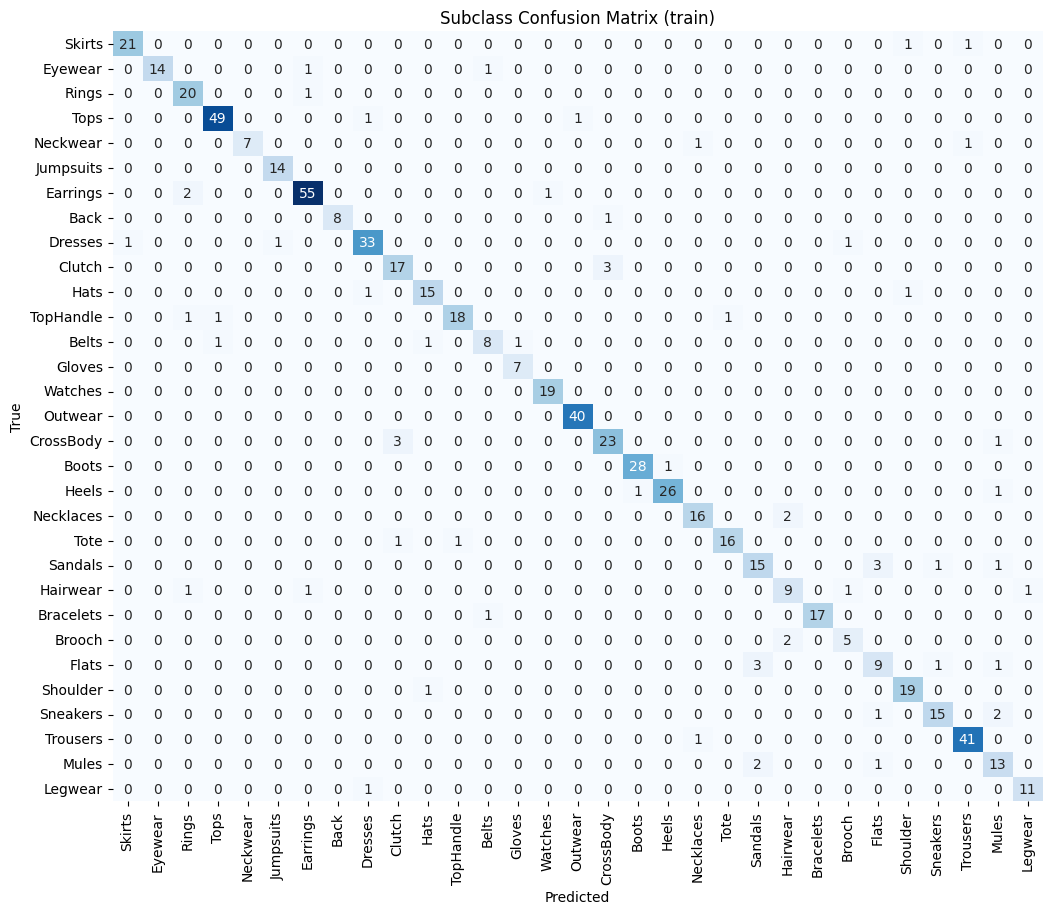

Final train F1 Score: 0.9050
Final train AUROC: 0.9388272709685922
Class: Skirts
  F1-score: 0.9333
  AUROC: 0.9557513231057815
Class: Eyewear
  F1-score: 0.9333
  AUROC: 0.9375
Class: Rings
  F1-score: 0.8889
  AUROC: 0.9731182795698925
Class: Tops
  F1-score: 0.9608
  AUROC: 0.9787818509046131
Class: Neckwear
  F1-score: 0.8750
  AUROC: 0.8888888888888888
Class: Jumpsuits
  F1-score: 0.9655
  AUROC: 0.9992401215805471
Class: Earrings
  F1-score: 0.9483
  AUROC: 0.9716949342918118
Class: Back
  F1-score: 0.9412
  AUROC: 0.9444444444444444
Class: Dresses
  F1-score: 0.9167
  AUROC: 0.9559748427672955
Class: Clutch
  F1-score: 0.8293
  AUROC: 0.9219325153374234
Class: Hats
  F1-score: 0.8824
  AUROC: 0.9396497530309833
Class: TopHandle
  F1-score: 0.9000
  AUROC: 0.9278033794162827
Class: Belts
  F1-score: 0.7619
  AUROC: 0.8621235043322789
Class: Gloves
  F1-score: 0.9333
  AUROC: 0.9992481203007519
Class: Watches
  F1-score: 0.9744
  AUROC: 0.9992343032159264
Class: Outwear
  F1-score

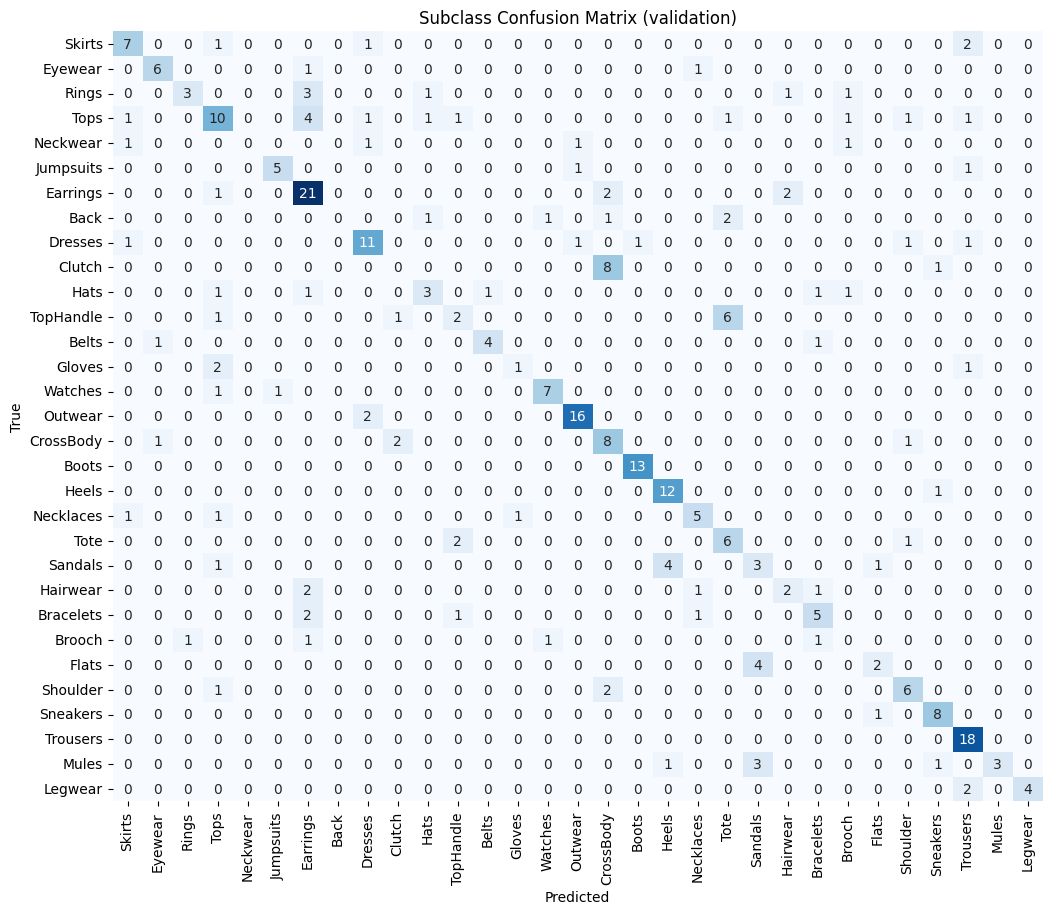

Final validation F1 Score: 0.5902
Final validation AUROC: 0.76085270715774
Class: Skirts
  F1-score: 0.6364
  AUROC: 0.8115151515151515
Class: Eyewear
  F1-score: 0.7500
  AUROC: 0.8716996699669968
Class: Rings
  F1-score: 0.4615
  AUROC: 0.6650110375275937
Class: Tops
  F1-score: 0.4762
  AUROC: 0.7099716892104435
Class: Neckwear
  F1-score: 0.0000
  AUROC: 0.5
Class: Jumpsuits
  F1-score: 0.7692
  AUROC: 0.855498120300752
Class: Earrings
  F1-score: 0.6885
  AUROC: 0.8792847503373818
Class: Back
  F1-score: 0.0000
  AUROC: 0.5
Class: Dresses
  F1-score: 0.6875
  AUROC: 0.8352754237288136
Class: Clutch
  F1-score: 0.0000
  AUROC: 0.49503311258278143
Class: Hats
  F1-score: 0.4286
  AUROC: 0.6825495049504949
Class: TopHandle
  F1-score: 0.2500
  AUROC: 0.5933554817275747
Class: Belts
  F1-score: 0.7273
  AUROC: 0.8316939890710382
Class: Gloves
  F1-score: 0.3333
  AUROC: 0.6233713355048859
Class: Watches
  F1-score: 0.7778
  AUROC: 0.8855776306107431
Class: Outwear
  F1-score: 0.8649
 

/tmp/ipykernel_591/1092189107.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/mnt/c/Users/user/Desktop/9444proj/VGG16_taskb_model.pth

Network(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

In [55]:
print(f'Using device: {device}')
num_epochs = 50

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

model, history = train_model(model, criterion_sub, optimizer, scheduler, num_epochs=num_epochs)

torch.save(model.state_dict(), '/mnt/c/Users/user/Desktop/9444proj/VGG16_taskb_model.pth')

model.load_state_dict(torch.load('/mnt/c/Users/user/Desktop/9444proj/VGG16_taskb_model.pth'))
model.eval()



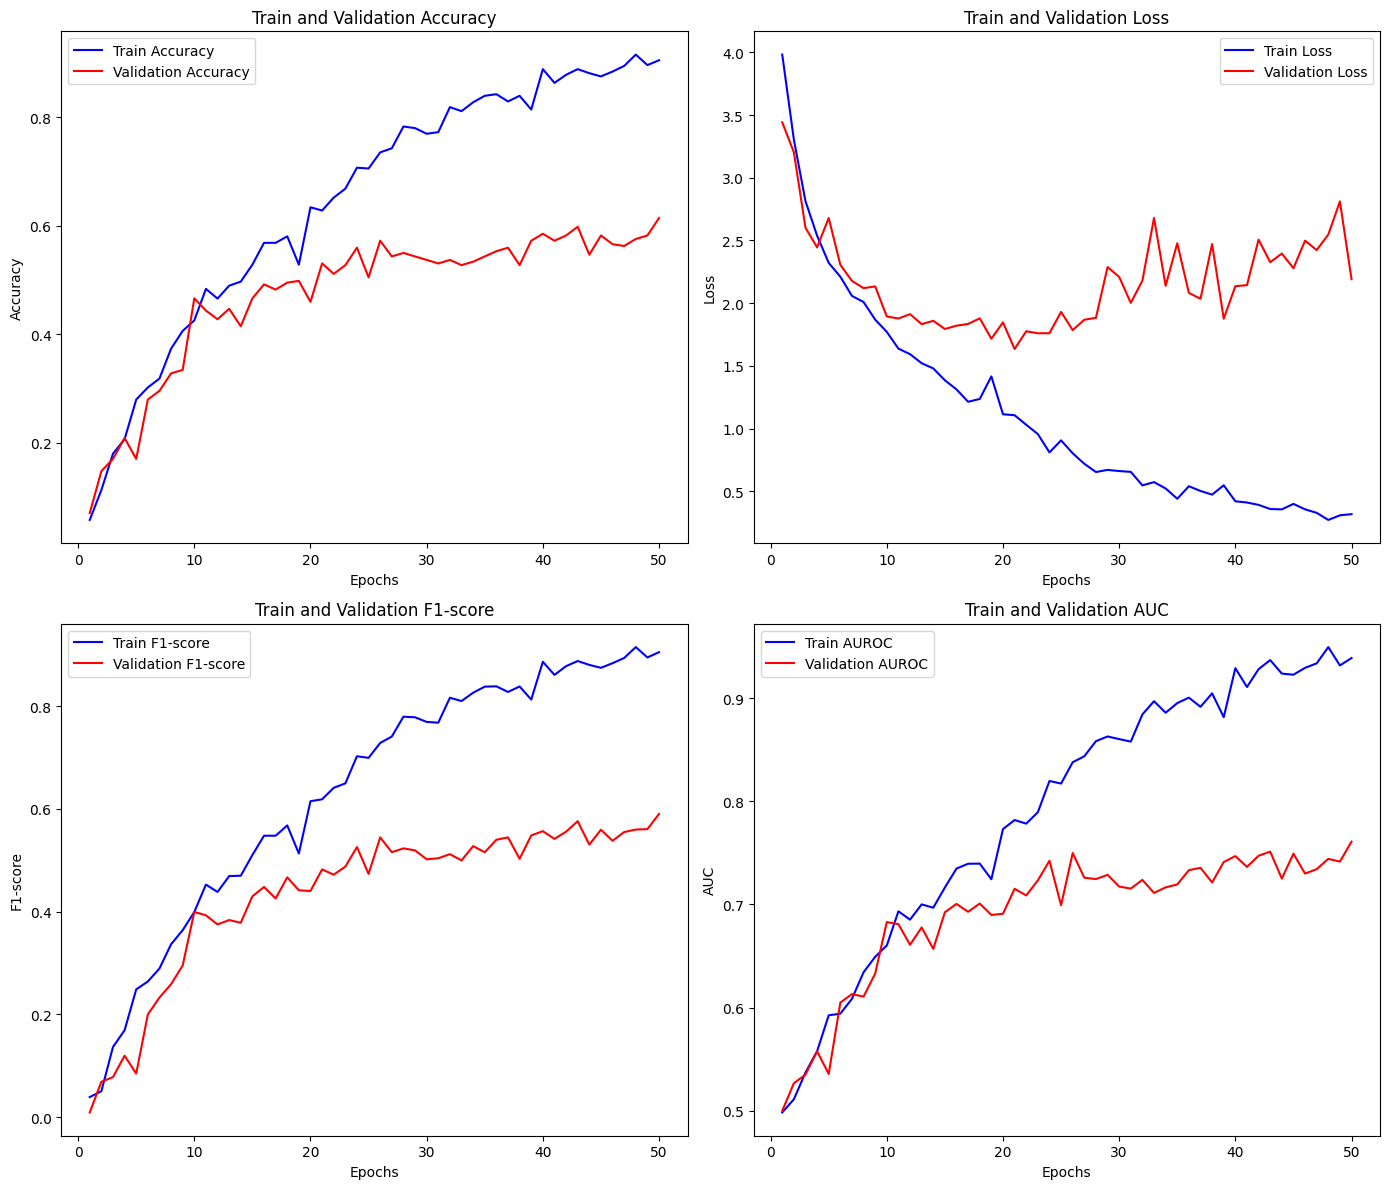

In [58]:
plot_training_history(history)

### Results

**Overall Metrics:**

- **Validation Loss:** 2.1914
- **Accuracy:** 0.6141
- **F1 Score:** 0.5902
- **AUROC:** 0.7609

**Class-wise Metrics:**

| Class       | F1-score | AUROC  |
|-------------|----------|--------|
| Skirts      | 0.6364   | 0.8115 |
| Eyewear     | 0.7500   | 0.8717 |
| Rings       | 0.4615   | 0.6650 |
| Tops        | 0.4762   | 0.7100 |
| Neckwear    | 0.0000   | 0.5000 |
| Jumpsuits   | 0.7692   | 0.8555 |
| Earrings    | 0.6885   | 0.8793 |
| Back        | 0.0000   | 0.5000 |
| Dresses     | 0.6875   | 0.8353 |
| Clutch      | 0.0000   | 0.4950 |
| Hats        | 0.4286   | 0.6825 |
| TopHandle   | 0.2500   | 0.5934 |
| Belts       | 0.7273   | 0.8317 |
| Gloves      | 0.3333   | 0.6234 |
| Watches     | 0.7778   | 0.8856 |
| Outwear     | 0.8649   | 0.9393 |
| CrossBody   | 0.4848   | 0.8116 |
| Boots       | 0.9630   | 0.9983 |
| Heels       | 0.8000   | 0.9531 |
| Necklaces   | 0.6250   | 0.8075 |
| Tote        | 0.5000   | 0.8184 |
| Sandals     | 0.3158   | 0.6551 |
| Hairwear    | 0.3636   | 0.6617 |
| Bracelets   | 0.5556   | 0.7712 |
| Brooch      | 0.0000   | 0.4935 |
| Flats       | 0.4000   | 0.6634 |
| Shoulder    | 0.6316   | 0.8267 |
| Sneakers    | 0.8000   | 0.9395 |
| Trousers    | 0.8182   | 0.9863 |
| Mules       | 0.5455   | 0.6875 |
| Legwear     | 0.8000   | 0.8333 |

**Final Validation Metrics:**

- **F1 Score:** 0.5902
- **AUROC:** 0.7609


## Discussions

We can see for main category classification. 20 epochs can achieve good performance, which shows our parameter tuning is successful. However, for subcategory classification, the pre-trained model will help the model to locate loss decrease faster. The initial weighted model will be stuck in the first or second epoch. Overfitting problem will occur around 15 epochs, the accuracy of training dataset will be over 0.9, while validation dataset will be only 0.6. The gap may be caused by extremely imbalanced data. Our effect for avoiding overfitting problem, mainly focus on setting drop out layer. We also tried to set weighted loss to solve quite low accuracy for less frequency classes, however it may improve less frequency classes prediction but it may cause high frequency item results are worse. In the real application, the sample distribution cannot represent the true sample weight, loss weight may be influenced by different sample distribution and batch size. In the future, we can design a specific algorithm to calculate the suitably weighted loss. 

Compared to the Resnet result, we can see that Resnet has an advantage in subcategory classification due to residual block; it helps Resnet increase dimension more deeply. However, VGG has an advantage in main category classification, indicated that simple task are more suitable for VGG architecture. 